# Network analytics project on the CFF railway network

Hereafter is the anlysis conducted on the CFF railway network extracted and cleaned. 

### Libraries

In [1]:
!pip uninstall -y ndlib

Uninstalling ndlib-3.1.2:
  Successfully uninstalled ndlib-3.1.2


In [2]:
!pip install git+https://github.com/CedricCook/ndlib

  Cloning https://github.com/CedricCook/ndlib to /private/var/folders/6y/6jmj4fm93xj8h9dt50wssf940000gn/T/pip-j5w6gf8o-build
  Running setup.py install for ndlib ... done


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ndlib

import warnings
warnings.filterwarnings('ignore')

### Import the graph

In [4]:
CFF_Graph = nx.read_gml('CFF_Graph_Final_2.gml')
print(nx.info(CFF_Graph))

Name: 
Type: Graph
Number of nodes: 17718
Number of edges: 21101
Average degree:   2.3819


As the average degree is really low (close to 2) we are almost dealing with a tree and therefore the graph will not be easy to draw. 

In [ ]:
nx.draw_networkx(CFF_Graph, pos=nx.spring_layout(CFF_Graph), with_labels=False, size = 15)
plt.show()

In [ ]:
nx.draw_circular(CFF_Graph, with_labels = False, size = 15)
plt.show()

In [ ]:
nx.draw_spectral(CFF_Graph, with_labels = False, size = 15)
plt.show()

In [ ]:
nx.draw_spring(CFF_Graph, with_labels = False, size = 15)
plt.show()

As the drawings are not very good looking with networkx, I will plot them with community detection method in the following paragraph. (I will perform this on the GCC)

# Diameter and average shortest path length with the GCC

To deal with the diameter and the average shortest path length, it is necessary to deal with the giant connected component of the graph. 

In [ ]:
# Extract the giant connected component to compute the diameter and the average shortest path length
CFF_Graph_GCC = max(nx.connected_component_subgraphs(CFF_Graph), key=len) 
print(nx.info(CFF_Graph_GCC))

In [ ]:
print('The diameter of the GCC is ', nx.diameter(CFF_Graph_GCC))
print('The average shortest path length of the GCC is ', nx.average_shortest_path_length(CFF_Graph_GCC))

These results are what one could expect. Indeed, these results tell us that the longest distance in the network is 58 which seem coherent with the size of Switzerland. Moreover, the average shortest path length is about 14 stops which mean that on average people can go from anywhere in Switzerland to anywhere else in 14 stops. (It is also coherent with the size of the country).

# Community Detection with the GCC

In this part, we will look at the different communities in the network. For this purpose, we will use the GCC in order to avoid single node community and to have a better understanding of what is goind on in the network. 

In [ ]:
# Install and import the Louvain algorithm
!pip install python-louvain
import community as community 

In [ ]:
# Create the best partition 
partition = community.best_partition(CFF_Graph_GCC)

In [ ]:
# Drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(CFF_Graph_GCC)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(CFF_Graph_GCC, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(CFF_Graph_GCC,pos, alpha=0.5)
plt.show()

This graph is not very signifiant. Let's plot the graph for each community.

In [ ]:
# Give the number of communities
size = int(len(set(partition.values())))
print('The number of communities: ', size)

This number of communities is coherent also with the size of the country. As we know that there are 26 "cantons" in Switzerland, we can see that there is almost 1.5/2 communities per canton which is reasonable (2 hubs per canton on average)

In [ ]:
# Function to plot each community 
def plot_community(G,number):
    # Get the list of nodes in community numbered "number"
    c = [nodes for nodes in partition.keys() if partition[nodes] == number]
    # Extract the graph
    T = G.subgraph(c)
    # Name the community
    degree = nx.degree(T)
    degree_sorted = sorted(degree, key=degree.__getitem__, reverse=True)
    if ((len(degree_sorted))!=0):
        title_com = degree_sorted[0]
        # Plot the subgraph
        nx.draw_networkx(T,pos=nx.spring_layout(T), with_labels=False, size = 15)
        plt.title(title_com)
        plt.show()
   

In [ ]:
# Display the 40 communities with title corresponding to the highest degree node
for i in range(size):
    plot_community(CFF_Graph,i+1)

As expected, most of the communities are associated with one big city/hubs in the different canton. Some of the communities correspond to smaller et more local region but overall the results are consistent. However we can notice that Lausanne seem not to have a community but is probably in the Montreux community. As I also take into account regional train, maybe Montreux has larger degree than Lausanne and it explains why the community is named "Montreux".

# Degree Distribution

In [ ]:
Degree_List = list(nx.degree(CFF_Graph).values())

plt.hist(Degree_List) # Plot the Frequency distribution linlin  
plt.xlabel('Degree')  
plt.ylabel('Frequency')
plt.title('Degree distribution CFF_Graph - LinLin')  
plt.show()

plt.hist(Degree_List, log = True)   # Plot the Frequency distribution loglin
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution CFF_Graph - LogLin')
plt.show()

plt.hist(Degree_List, normed=True) # Plot the probability distribution linlin  
plt.xlabel('Degree')  
plt.ylabel('Probability*bins_width')
plt.title('Degree distribution CFF_Graph - LinLin')  
plt.show()

plt.hist(Degree_List, log = True, normed = True)   # Plot the Frequency distribution loglin
plt.xlabel('Degree')
plt.ylabel('Probability*bins_width')
plt.title('Degree distribution CFF_Graph - LogLin')
plt.show()

These graphs show us that the degree distribution seems to be like an decreasing exponential one (like a Poisson law maybe). It is coherent as we consider many small, regional and isolated stop with 1 or 2 connections. As expected, there is a few big hubs connected to more than 20 other stops. 

# Density, local and overall clustering

In [ ]:
print('The average clustering coefficient for the network is', nx.average_clustering(CFF_Graph))
print('The overall clustering coefficient for the network is', nx.transitivity(CFF_Graph))
print('The density of the network is', nx.density(CFF_Graph))
print(CFF_Graph)

The clustering coefficient and the density of the network are quite low. As expected the network is really sparse as we take into account really small regional stops. 

# Centrality Measures

Hereafter are listed all the different centrality measure seen in class.

### Degree Centrality

In [ ]:
# Degree centrality 
Degree_Centrality = nx.degree(CFF_Graph)

In [ ]:
# Highest nodes for degree centrality
Degree_Centrality_Sorted = sorted(Degree_Centrality, key=Degree_Centrality.__getitem__, reverse=True)
print('The top 20 nodes for degree centrality are:')
for i in range(20):
    print(Degree_Centrality_Sorted[i])

### Closeness Centrality

In [ ]:
# Closeness Centrality
Close_Centrality = nx.closeness_centrality(CFF_Graph)

In [ ]:
# Highest nodes for closeness
Close_Centrality_Sorted = sorted(Close_Centrality, key=Close_Centrality.__getitem__, reverse=True)
print('The top 20 nodes for closeness centrality are:')
for i in range(20):
    print(Close_Centrality_Sorted[i])

### Betweenness Centrality

In [ ]:
# Betweenness centrality
Between_Centrality = nx.betweenness_centrality(CFF_Graph)

In [ ]:
# Highest nodes for betweenness
Between_Centrality_Sorted = sorted(Between_Centrality, key=Between_Centrality.__getitem__, reverse=True)
print('The top 20 nodes for betweenness centrality are:')
for i in range(20):
    print(Between_Centrality_Sorted[i])

### Page Rank

In [ ]:
# Page rank 
Page_Rank = nx.pagerank(CFF_Graph)

In [ ]:
# Highest nodes for Page rank measure
Page_Rank_Sorted = sorted(Page_Rank, key=Page_Rank.__getitem__, reverse=True)
print('The top 20 nodes for page rank are:')
for i in range(20):
    print(Page_Rank_Sorted[i])

### EigenVector Centrality

In [ ]:
# EigenVector centrality 
EigenVector_Centrality = nx.eigenvector_centrality(CFF_Graph)

In [ ]:
# Highest nodes for EigenVector Centrality 
EigenVector_Centrality_Sorted = sorted(EigenVector_Centrality, key=EigenVector_Centrality.__getitem__, reverse=True)
print('The top 20 nodes for eigenvector centrality are:')
for i in range(20):
    print(EigenVector_Centrality_Sorted[i])

Again, as we could expect, the centrality measures return all the big hubs in Switzerland like Zurich, Lausanne, Geneve, Bern, Otlen, Bale, Luzern,..
It therefore shows that these cities are the most "important" ones in the railway network of Switzerland. 

# Homophily

This anlysis can maybe be conducted by canton if we can find an easy and automatized way to affect a canton value to a station or a stop. I don't have time to do it now but it can be a good analysis for the final project. 

# Ties strength analysis (Neighborhood overlap)

Let's report the code generated in Assignment 2 to calculate the neighborhood overlap

In [ ]:
neigh_overlap = dict()  # Create the dictionnary of the neighbourhood overlap

for e in CFF_Graph.edges():
    source = e[0]
    sink = e[1]
    neigh_source = list(nx.all_neighbors(CFF_Graph,source)) # list of neighbors of the source vertex
    neigh_sink = list(nx.all_neighbors(CFF_Graph,sink)) # list of neighbors of the sink vertex
    
    neigh_source.remove(sink) # The sink node is not included in the number of neighbors according to Easley and Kleinberg
    neigh_sink.remove(source) # The source node is not included in the number of neighbors according to Easley and Kleinberg
    
    common_neighbors = len(list(nx.common_neighbors(CFF_Graph,source,sink))) # number of common neighbors
    at_least_one = len(neigh_source) + len(neigh_sink) - common_neighbors # number of neighbors of at least one node 
    if (at_least_one == 0):
        print('The nodes', source, 'and', sink, 'are isolated.')
    else:
        ratio = common_neighbors/at_least_one
        neigh_overlap[e] = ratio
    

Let's now look at the neighborhood overlap distribution 

In [ ]:
list_overlap = list(neigh_overlap.values()) # List of the overlap coefficients
plt.hist(list_overlap)    
plt.xlabel('Neighbourhood Overlap')
plt.ylabel('Frequency')
plt.title('Neighbourhood Overlap frequency distribution')
plt.show()

As expected there is a lot of zeros as many stops are not hubs but small stops with just two neighbors (the previous and the next one of a line)

Let's look at the lowest and highest links to confirm

In [ ]:
sorted_overlap = sorted(neigh_overlap, key=neigh_overlap.__getitem__)

# Print the 20 links with lowest overlap
print('The 20 lowest links for the neighborhood overlap are:')
for i in range(20):
    print(sorted_overlap[i])
    
# Print the 20 links with highest overlap
print('\n The 20 highest links for the neighborhood overlap are:')
for i in range(20):
    print(sorted_overlap[-i-1])

The analysis of the neighborhood overlap is really strange for this network. Indeed, due to regional trains the results are falsed by all the small connections. It will require to aggregate some of the data to have a better view on the neighborhood overlap.

## Infection model 

In this part we will analyse the spread of an infection accross Switzerland. We are going to use a SIR model. The probability of infection will be define as follow: 
- Probability constant for a bus infection
- Probability proportional to the population of the city for the train station

In [5]:
import ndlib.models.epidemics.SIRNodewiseModel as sir
import ndlib.models.ModelConfig as mc

In [6]:
MAX_POPULATION = 390000

In [7]:
data_stops_with_population = pd.read_csv('stops_with_population.csv')
for node in CFF_Graph.nodes():
    pop_values = data_stops_with_population.loc[data_stops_with_population['stop'] == node]['population'].values
    if len(pop_values) > 0:
        population = pop_values[0]
    else:
        population = None
        
    CFF_Graph.node[node]['population'] = population

In [8]:
print(CFF_Graph.node['Zürich HB'])

{'ids': ['8503000:0:15', '8503000:0:41/42', '8503000:0:10', '8503000:0:17', '8503000', '8503000:0:8', '8503000:0:16', '8503000:0:18', '8503000:0:14', '8503000:0:12', '8503000:0:43/44', '8503000:0:13', '8503000:0:11', '8503000:0:9', '8503000:0:6', '8503000:0:31', '8503000:0:34', '8503000:0:5', '8503000:0:4', '8503000:0:32', '8503000:0:7', '8503000:0:3', '8503000:0:33'], 'lat': 47.3784803529949, 'lon': 8.540193575784679, 'NodeType': 'Train', 'population': 387225}


In [9]:
def sir_nw(infected_nodes, nb_iter):
    # Create the SIR model 
    sir_model = sir.SIRNodewiseModel(CFF_Graph)

    # Initialize the parameter for the diffusion model
    sir_cfg = mc.Configuration()
#     sir_cfg.add_model_parameter('beta', 0.01)
    sir_cfg.add_model_parameter('gamma', 0.005)
    
    for node in CFF_Graph.nodes():
        population = CFF_Graph.node[node]['population']
        node_beta = 0.05 # default for bus stops
        if population == -1:
            node_beta = 0.05
        elif population > 0:
            node_beta = population / MAX_POPULATION
            
        sir_cfg.add_node_configuration('beta', node, node_beta)
    
    sir_cfg.add_model_initial_configuration("Infected", infected_nodes)

    sir_model.set_initial_status(sir_cfg)
    
    # Calculate the nb_ite iterations and the trends
    sir_iter = sir_model.iteration_bunch(nb_iter)
    
    return sir_model, sir_iter

In [10]:
model, iters = sir_nw(['Lausanne'], 200)
print(iters[-1]['node_count'])

{0: 17421, 1: 197, 2: 100}


In [11]:
import ndlib.viz.mpl.DiffusionTrend as dt

no display found. Using non-interactive Agg backend


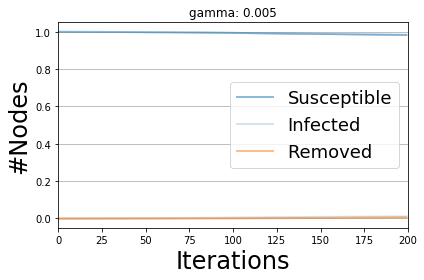

In [12]:
# Simulation execution
trends = model.build_trends(iters)

# Visualization
viz = dt.DiffusionTrend(model, trends)
viz.plot()

Print the screenshot of the diffusion trend after